In [480]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import seaborn as sns
import os
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


In [481]:
# # check installed version
# import pycaret
# pycaret.__version__

In [482]:
# Retrieve path and load the data
path = os.getcwd()
dr = pd.read_csv(path+"/train.csv")
dt = pd.read_csv(path+"/test.csv")

# Number of rows and columns
print('dr train', dr.shape)
print('df test', dt.shape)

dt.head(3)

dr train (6895, 70)
df test (767, 69)


,id,short_name,overall,potential,value_eur,wage_eur,birthday_date,height_cm,weight_kg,club_name,league_name,league_level,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_name,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
0,215562,R. Hunt,63,63,475000.0,3000,1995-07-07,171,67,Swindon Town,English League Two,4,24,NaN,2019-06-24,2022,England,NaN,Right,5,2,1,High/Medium,Normal (170-185),No,831000.0,NaN,NaN,76.0,33.0,55.0,64.0,56.0,62.0,62,29,50,57,23,61,62,55,51,59,74,77,84,55,88,45,84,80,55,28,51,57,51,44,36,57,54,59,58,15,12,12,11,15,NaN
1,248311,Tiri,64,64,500000.0,950,1991-07-14,186,84,ATK Mohun Bagan FC,Indian Super League,1,44,NaN,2020-09-12,2023,Spain,NaN,Left,3,2,1,Medium/Medium,Normal (185+),No,675000.0,NaN,"Leadership, Power Header",65.0,38.0,53.0,52.0,62.0,78.0,60,28,62,56,55,53,31,35,57,50,64,66,52,59,45,56,88,74,83,38,66,59,43,48,33,55,63,63,64,9,14,9,11,6,NaN
2,223933,G. Nilsson,64,70,925000.0,2000,1997-05-23,197,87,SV Wehen Wiesbaden,German 3. Bundesliga,3,29,NaN,2021-01-05,2023,Sweden,NaN,Right,2,2,1,Medium/Medium,Lean (185+),No,1500000.0,NaN,Injury Prone,77.0,62.0,48.0,59.0,27.0,71.0,35,63,68,56,61,61,47,38,44,62,73,80,44,59,48,67,50,69,79,56,59,20,60,53,65,55,23,25,19,6,7,8,16,14,NaN


In [483]:
# Create column to differentiate train from test
dr['is_test'] = 0
dt['is_test'] = 1
# union both datasets
df = pd.concat([dr, dt])
# Unit test
dr.shape[0] + dt.shape[0] == df.shape[0]
# Unit test
df['is_test'].value_counts()

0    6895
1     767
Name: is_test, dtype: int64

In [484]:
df.columns

Index(['id', 'short_name', 'overall', 'potential', 'value_eur', 'wage_eur',
       'birthday_date', 'height_cm', 'weight_kg', 'club_name', 'league_name',
       'league_level', 'club_jersey_number', 'club_loaned_from', 'club_joined',
       'club_contract_valid_until', 'nationality_name', 'nation_jersey_number',
       'preferred_foot', 'weak_foot', 'skill_moves',
       'international_reputation', 'work_rate', 'body_type', 'real_face',
       'release_clause_eur', 'player_tags', 'player_traits', 'pace',
       'shooting', 'passing', 'dribbling', 'defending', 'physic',
       'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'pow

## Dealing with NA

In [485]:
# Function to create table of missing values
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

                # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [486]:
# Check the NAs
print(missing_values_table(df))

Your selected dataframe has 71 columns.
There are 15 columns that have missing values.
                      Missing Values  % of Total Values
club_loaned_from                7266               94.8
nation_jersey_number            7198               93.9
goalkeeping_speed               6961               90.9
player_tags                     6806               88.8
player_traits                   2874               37.5
position                         767               10.0
pace                             701                9.1
shooting                         701                9.1
passing                          701                9.1
dribbling                        701                9.1
defending                        701                9.1
physic                           701                9.1
release_clause_eur               401                5.2
club_joined                      396                5.2
value_eur                          5                0.1


In [487]:
columns_to_drop = ['club_loaned_from', 'nation_jersey_number', 'player_tags']
df = df.drop(columns=columns_to_drop)

In [488]:
# Function to impute NA with 0
def impute_column_with_zero(df, column_name):
    df[column_name] = df[column_name].fillna(0)
    return df

df = impute_column_with_zero(df, 'goalkeeping_speed')

In [489]:
# Check the NAs
print(missing_values_table(df))

Your selected dataframe has 68 columns.
There are 11 columns that have missing values.
                    Missing Values  % of Total Values
player_traits                 2874               37.5
position                       767               10.0
pace                           701                9.1
shooting                       701                9.1
passing                        701                9.1
dribbling                      701                9.1
defending                      701                9.1
physic                         701                9.1
release_clause_eur             401                5.2
club_joined                    396                5.2
value_eur                        5                0.1


Ideas, what to do with variables:
short_name - drop
birthday_date - divide by year, month, day - for regression will need only year, so we can replace just by year + dummies, it's categorical
club_name - encode by ... - but does it really matter for the position?
league_name - encode by ... - but does it really matter for the position?
nationality_name - dummies (we have big dataset, can have lots of dummies) - but does it really matter for the position?
club_joined - divide by year, month, day - for regression will need only year, so we can replace just by year - but does it really matter for the position?
preffered_foot - dummy
real_face - dummy
work_rate - find unique values - rating or dummies (there are strange values i can not interpret - so dummies)
body_type - check unique values, then divide word, first number in the bracket, second number in the bracket after -, we actually have height already, so we can keep only type and encode with rating
player_traits - don't know really... have to use some variables to encode and impute as well=)

In [490]:
# Set display option to show all columns
pd.set_option('display.max_columns', None)

# Display the DataFrame
print(df.head(1))

       id short_name  overall  potential  value_eur  wage_eur birthday_date  \
0  216302  E. García       71         71  1400000.0     10000    1989-12-28   

   height_cm  weight_kg                  club_name      league_name  \
0        176         73  Club Atlético de San Luis  Mexican Liga MX   

   league_level  club_jersey_number club_joined  club_contract_valid_until  \
0             1                  29  2021-07-12                       2026   

  nationality_name preferred_foot  weak_foot  skill_moves  \
0           Mexico          Right          5            3   

   international_reputation    work_rate         body_type real_face  \
0                         1  Medium/High  Normal (170-185)        No   

   release_clause_eur  player_traits  pace  shooting  passing  dribbling  \
0           2400000.0  Early Crosser  70.0      52.0     60.0       70.0   

   defending  physic  attacking_crossing  attacking_finishing  \
0       67.0    66.0                  64               

In [491]:
# # Dealing with dates (will keep only year)
# def replace_date_with_year(df, date_columns):
#     for column in date_columns:
#         df[column] = pd.to_datetime(df[column]).dt.year
#     return df

# # Columns to replace values with the year
# date_columns = ['birthday_date', 'club_joined']

# # Apply the function
# df = replace_date_with_year(df, date_columns)

# # Display the resulting DataFrame
# print(df.head())

In [492]:
# Calculate age of players
df['birthday_date'] = pd.to_datetime(df['birthday_date'], format='%Y-%m-%d', errors='coerce')
df['today'] = pd.to_datetime('2022-11-01',format='%Y-%m-%d', errors='coerce')


df['age'] = ((df['today'] - df['birthday_date'])/np.timedelta64(1, 'Y'))
df['age'] = df['age'].astype(int)

In [493]:
# Calculate the number of years in the club
df['club_joined'] = pd.to_datetime(df['club_joined'], format='%Y-%m-%d', errors='coerce')
df['today'] = pd.to_datetime('2022-11-01', format='%Y-%m-%d', errors='coerce')

# Calculate the years_in_club only if 'club_joined' is not NA
df['years_in_club'] = np.where(df['club_joined'].notna(), ((df['today'] - df['club_joined']) / np.timedelta64(1, 'Y')), np.nan)
df['years_in_club'] = df['years_in_club'].astype(float).round(2)

# Drop the 'club_joined' column
df = df.drop('club_joined', axis=1)

In [494]:
# Specify the columns to impute
columns_to_impute = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'release_clause_eur', 'value_eur', 'years_in_club']

# Create a KNNImputer object with k=3 
imputer = KNNImputer(n_neighbors=3) 

# Perform KNN imputation only on the specified columns for the training data
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

In [495]:
# Check the NAs
print(missing_values_table(df))

Your selected dataframe has 70 columns.
There are 2 columns that have missing values.
               Missing Values  % of Total Values
player_traits            2874               37.5
position                  767               10.0


## Outliers and Unique Values

In [496]:
def plot_boxplots(data, variables, plots_per_row=2):
    num_variables = len(variables)
    num_rows = math.ceil(num_variables / plots_per_row)

    fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(12, 4 * num_rows))
    fig.subplots_adjust(hspace=0.5)

    for i, variable in enumerate(variables):
        row, col = divmod(i, plots_per_row)
        ax = axes[row, col] if num_rows > 1 else axes[col]

        ax.boxplot(data[variable])
        ax.set_title(f'Boxplot of {variable}')
        ax.set_ylabel(variable)

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    plt.show()

In [497]:
num_vars = ['id',  'overall', 'potential', 'value_eur', 'wage_eur',
       'height_cm', 'weight_kg',
       'league_level', 'club_jersey_number', 
       'club_contract_valid_until',
       'weak_foot', 'skill_moves',
       'international_reputation', 
       'release_clause_eur', 'pace',
       'shooting', 'passing', 'dribbling', 'defending', 'physic',
       'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes']

non_num_vars = ['birthday_date', 'position', 'short_name', 'birthday_date', 'club_name', 'league_name', 'nationality_name', 'preferred_foot', 'work_rate', 'body_type', 'real_face', 'player_traits', ]

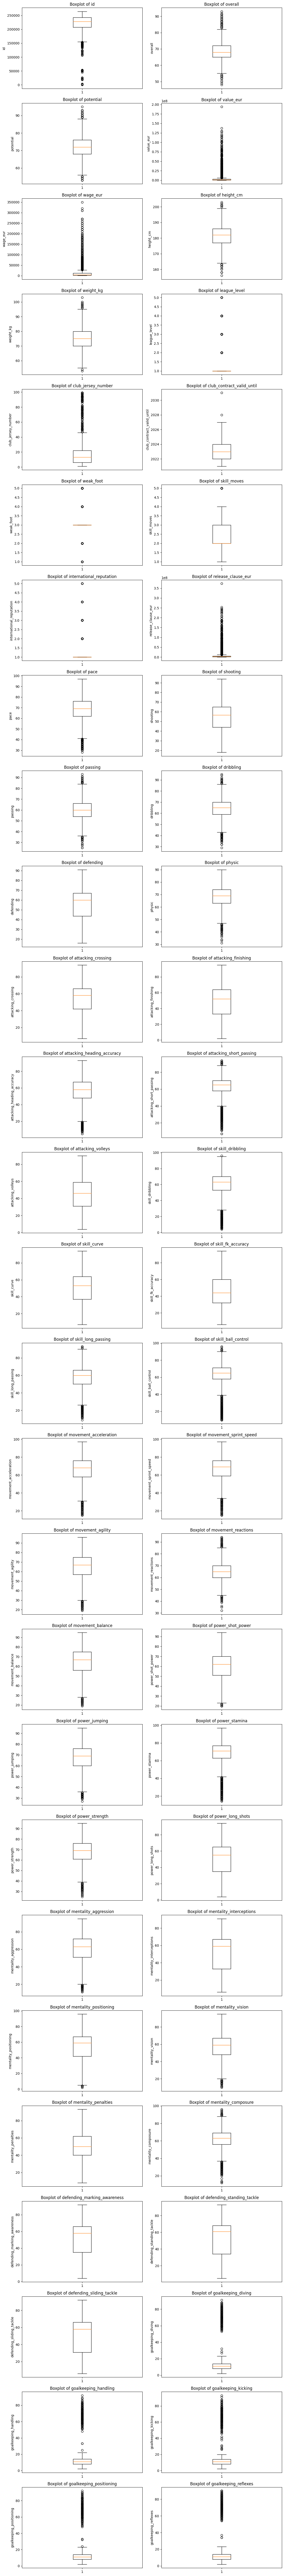

In [498]:
# Execute
columns = num_vars
plot_boxplots(df, columns, plots_per_row=2)

In [499]:
# Custom function to calculate the number of unique values for given columns
def calculate_unique_counts(dataframe, columns):
    unique_counts = {}
    for column in columns:
        unique_count = dataframe[column].nunique()
        unique_counts[column] = unique_count
    return unique_counts

# List of columns for which you want to calculate unique counts
columns_to_check = non_num_vars

# Calculate unique counts for the specified columns
unique_counts = calculate_unique_counts(df, columns_to_check)

# Print the results
for column, count in unique_counts.items():
    print(f"Number of unique values in {column}: {count}")

Number of unique values in birthday_date: 4214
Number of unique values in position: 24
Number of unique values in short_name: 7418
Number of unique values in club_name: 701
Number of unique values in league_name: 55
Number of unique values in nationality_name: 144
Number of unique values in preferred_foot: 2
Number of unique values in work_rate: 9
Number of unique values in body_type: 10
Number of unique values in real_face: 2
Number of unique values in player_traits: 825


In [500]:
# Unique values for strings
def calculate_value_counts(df, columns, top_n=10):
    
    for column in columns:
        # Calculate the count of each unique value
        value_counts = df[column].value_counts()

        # Calculate the percentage of each unique value
        percentage = (value_counts / len(df)) * 100

        # Create a new DataFrame to display the results
        result_df = pd.DataFrame({column: value_counts.index, 'Count': value_counts, 'Percentage': percentage})

        # Display the top values
        print(result_df.head(top_n))

# Example usage with multiple columns
columns = ['preferred_foot', 'work_rate', 'body_type', 'real_face']
calculate_value_counts(df, columns, top_n=10)

      preferred_foot  Count  Percentage
Right          Right   5779   75.424171
Left            Left   1883   24.575829
                   work_rate  Count  Percentage
Medium/Medium  Medium/Medium   3477   45.379796
High/Medium      High/Medium   1635   21.339076
Medium/High      Medium/High    944   12.320543
High/High          High/High    592    7.726442
High/Low            High/Low    326    4.254764
Medium/Low        Medium/Low    276    3.602193
Low/High            Low/High    217    2.832159
Low/Medium        Low/Medium    181    2.362307
Low/Low              Low/Low     14    0.182720
                         body_type  Count  Percentage
Normal (170-185)  Normal (170-185)   2758   35.995824
Normal (185+)        Normal (185+)   1810   23.623075
Lean (170-185)      Lean (170-185)   1400   18.271992
Lean (185+)            Lean (185+)    702    9.162099
Normal (170-)        Normal (170-)    276    3.602193
Stocky (170-185)  Stocky (170-185)    256    3.341164
Stocky (185+)        S

In [501]:
# Unique values for player_traits
columns = ['player_traits']
calculate_value_counts(df, columns, top_n=50)

                                                                                        player_traits  \
Speed Dribbler (AI)                                                               Speed Dribbler (AI)   
Power Header                                                                             Power Header   
Dives Into Tackles (AI)                                                       Dives Into Tackles (AI)   
Long Passer (AI)                                                                     Long Passer (AI)   
Long Shot Taker (AI)                                                             Long Shot Taker (AI)   
Injury Prone                                                                             Injury Prone   
Technical Dribbler (AI)                                                       Technical Dribbler (AI)   
Leadership                                                                                 Leadership   
Early Crosser                                          

## Correlations

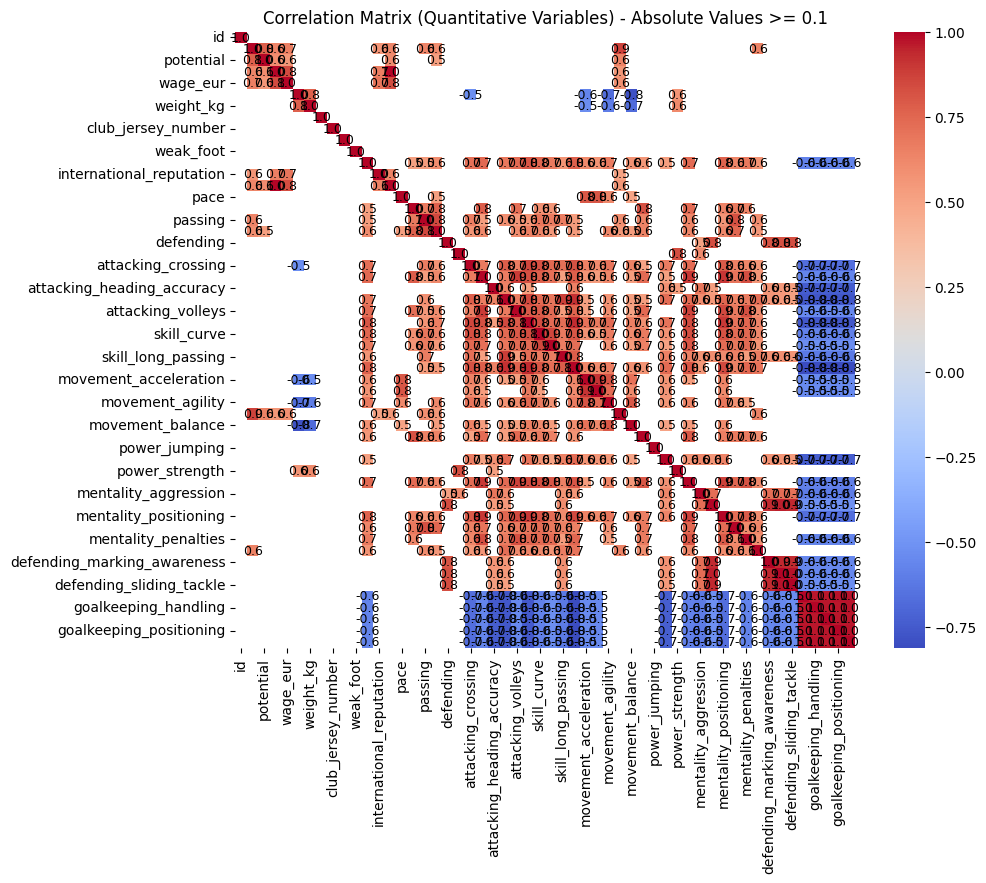

In [502]:
# Correlations among the variables with abs(correlation) >= 0.1
df_for_heatmap = df[['id',  'overall', 'potential', 'value_eur', 'wage_eur',
       'height_cm', 'weight_kg',
       'league_level', 'club_jersey_number', 
       'club_contract_valid_until',
       'weak_foot', 'skill_moves',
       'international_reputation', 
       'release_clause_eur', 'pace',
       'shooting', 'passing', 'dribbling', 'defending', 'physic',
       'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes']]
df_for_heatmap_corr = df_for_heatmap.corr()

# Filter correlations with abs(correlation) >= 0.1
mask = (df_for_heatmap_corr.abs() >= 0.5)
df_for_heatmap_corr_filtered = df_for_heatmap_corr[mask]

# Plot correlations with adjusted font size and text color
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(df_for_heatmap_corr_filtered, annot=True, cmap='coolwarm', fmt=".1f", annot_kws={"size": 9, "color": "black"})
plt.title('Correlation Matrix (Quantitative Variables) - Absolute Values >= 0.1')
plt.show()

## Encoding

In [503]:
# Dealing with body_type
# body_type                                            
# Normal (170-185)  Normal (170-185)   1409   37.643601
# Lean (170-185)      Lean (170-185)    768   20.518301
# Normal (185+)        Normal (185+)    711   18.995458
# Lean (185+)            Lean (185+)    268    7.160032
# Normal (170-)        Normal (170-)    168    4.488378
# Stocky (170-185)  Stocky (170-185)    148    3.954048
# Lean (170-)            Lean (170-)     87    2.324339
# Unique                      Unique     76    2.030457
# Stocky (185+)        Stocky (185+)     73    1.950307
# Stocky (170-)        Stocky (170-)     35    0.935079
# As far as we already have height, i'll replace values with Normal/Lean/Stocky/Unique and then create dummies

# Replace values with the word before parenthesis
df['body_type'] = df['body_type'].str.extract(r'(\w+)\s*\(')

# Keep "Unique" if it is present in the original column
df.loc[df['body_type'].isna(), 'body_type'] = 'Unique'

# Display the resulting DataFrame
print(df.head())

       id   short_name  overall  potential  value_eur  wage_eur birthday_date  \
0  216302    E. García       71         71  1400000.0     10000    1989-12-28   
1  237867   D. Cancola       65         71  1000000.0      2000    1996-10-23   
2  253472      E. Kahl       65         77  1600000.0      2000    2001-09-27   
3  223994    S. Mugoša       72         72  2300000.0      5000    1992-02-26   
4  251635  A. Țigănașu       65         65   525000.0      3000    1990-06-12   

   height_cm  weight_kg                  club_name           league_name  \
0        176         73  Club Atlético de San Luis       Mexican Liga MX   
1        183         73             Ross County FC  Scottish Premiership   
2        178         69                  Aarhus GF      Danish Superliga   
3        188         81          Incheon United FC     Korean K League 1   
4        179         74                FC Botoşani       Romanian Liga I   

   league_level  club_jersey_number  club_contract_valid

In [504]:
# Function to create dummies
def one_hot(df, columns):
    dummy = pd.get_dummies(df[columns])
    encoded_df = pd.concat([df, dummy], axis=1)
    return encoded_df

# Columns to create dummies for
columns_to_encode = ['preferred_foot', 'body_type', 'nationality_name']

# Apply the one_hot function
df = one_hot(df, columns_to_encode)

# Drop the original columns after creating dummies
df = df.drop(columns=columns_to_encode)

# Display the resulting DataFrame
print(df.head())

       id   short_name  overall  potential  value_eur  wage_eur birthday_date  \
0  216302    E. García       71         71  1400000.0     10000    1989-12-28   
1  237867   D. Cancola       65         71  1000000.0      2000    1996-10-23   
2  253472      E. Kahl       65         77  1600000.0      2000    2001-09-27   
3  223994    S. Mugoša       72         72  2300000.0      5000    1992-02-26   
4  251635  A. Țigănașu       65         65   525000.0      3000    1990-06-12   

   height_cm  weight_kg                  club_name           league_name  \
0        176         73  Club Atlético de San Luis       Mexican Liga MX   
1        183         73             Ross County FC  Scottish Premiership   
2        178         69                  Aarhus GF      Danish Superliga   
3        188         81          Incheon United FC     Korean K League 1   
4        179         74                FC Botoşani       Romanian Liga I   

   league_level  club_jersey_number  club_contract_valid

In [505]:
# Dealing with work_rate                                      
# Medium/Medium Medium/Medium   1231   32.888058
# High/Medium      High/Medium   1005   26.850120
# Medium/High      Medium/High    511   13.652151
# High/High          High/High    409   10.927064
# High/Low            High/Low    215    5.744056
# Medium/Low        Medium/Low    170    4.541811
# Low/High            Low/High    118    3.152551
# Low/Medium        Low/Medium     76    2.030457
# Low/Low              Low/Low      8    0.213732
# Function to create "Attacking" and "Defensive" columns
def split_work_rate(df, column_name):
    # Split the values in the column by '/'
    split_values = df[column_name].str.split('/', expand=True)

    # Create new columns "Attacking" and "Defensive"
    df['Attacking'] = split_values[0]
    df['Defensive'] = split_values[1]

    # Drop the original "work_rate" column
    df = df.drop(column_name, axis=1)

    return df

# Apply the function to your DataFrame
df = split_work_rate(df, 'work_rate')

In [506]:
def label_encode(df, columns):
    label_mapping = {'High': 3, 'Medium': 2, 'Low': 1}

    for column in columns:
        # Use map function to replace values based on the label_mapping dictionary
        df[column] = df[column].map(label_mapping)

    return df

# Apply label encoding to "Attacking" and "Defensive" columns
columns_to_encode = ['Attacking', 'Defensive']
df = label_encode(df, columns_to_encode)

# Display the resulting DataFrame
print(df.head(1))


       id short_name  overall  potential  value_eur  wage_eur birthday_date  \
0  216302  E. García       71         71  1400000.0     10000    1989-12-28   

   height_cm  weight_kg                  club_name      league_name  \
0        176         73  Club Atlético de San Luis  Mexican Liga MX   

   league_level  club_jersey_number  club_contract_valid_until  weak_foot  \
0             1                  29                       2026          5   

   skill_moves  international_reputation real_face  release_clause_eur  \
0            3                         1        No           2400000.0   

   player_traits  pace  shooting  passing  dribbling  defending  physic  \
0  Early Crosser  70.0      52.0     60.0       70.0       67.0    66.0   

   attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
0                  64                   40                          56   

   attacking_short_passing  attacking_volleys  skill_dribbling  skill_curve  \
0              

In [507]:
# # Moved earlier to deal with NaNs
# # Dealing with dates (will keep only year)
# def replace_date_with_year(df, date_columns):
#     for column in date_columns:
#         df[column] = pd.to_datetime(df[column]).dt.year
#     return df

# # Columns to replace values with the year
# date_columns = ['birthday_date', 'club_joined']

# # Apply the function
# df = replace_date_with_year(df, date_columns)

# # Display the resulting DataFrame
# print(df.head())


In [508]:
# # Dummy for the year of birth
# dummy_year = pd.get_dummies(df['birthday_date'], prefix= 'Year').astype(int)
# df = pd.concat([df, dummy_year], axis=1)
# print(df.head())

In [509]:
# # Function for target encoding
# # Left the columns i used to encode on so far - will drop it later because of collinearity (but probably in case of body_type will drop it and keep weight and actuallly the same for other variables i'm encoding)

# def target_encode(df, encoding_dict):
#     for group_by_column, encode_column in encoding_dict.items():
#         # Calculate mean encoding for each group
#         mean_encoding = df.groupby(group_by_column)[encode_column].mean()
        
#         # Map the mean encoding values back to the original DataFrame
#         df[f'{encode_column}_target_encoded'] = df[group_by_column].map(mean_encoding)
    
#     return df

# # Dictionary for target encoding {group_by_column: encode_column}
# encoding_dict = {'columns?': 'nationality_name', 'columns?': 'club_name', 'columns?': 'league_name'}

# # Apply the function
# df = target_encode(df, encoding_dict)

# # Display the resulting DataFrame
# print(df.head())




## Player Traits

In [510]:
# Function to remove (AI) - don't know, what is that

def remove_ai(df, column):
    df[column] = df[column].str.replace(r'\s*\([^)]*\)', '', regex=True)
    return df

# Column to process
column = 'player_traits'

# Apply the function
df = remove_ai(df, column)

# Display the resulting DataFrame
print(df.head())


       id   short_name  overall  potential  value_eur  wage_eur birthday_date  \
0  216302    E. García       71         71  1400000.0     10000    1989-12-28   
1  237867   D. Cancola       65         71  1000000.0      2000    1996-10-23   
2  253472      E. Kahl       65         77  1600000.0      2000    2001-09-27   
3  223994    S. Mugoša       72         72  2300000.0      5000    1992-02-26   
4  251635  A. Țigănașu       65         65   525000.0      3000    1990-06-12   

   height_cm  weight_kg                  club_name           league_name  \
0        176         73  Club Atlético de San Luis       Mexican Liga MX   
1        183         73             Ross County FC  Scottish Premiership   
2        178         69                  Aarhus GF      Danish Superliga   
3        188         81          Incheon United FC     Korean K League 1   
4        179         74                FC Botoşani       Romanian Liga I   

   league_level  club_jersey_number  club_contract_valid

In [511]:
# Ensure all values are strings and split each entry into a list of traits
traits_lists = [str(value).split(', ') if pd.notna(value) else [] for value in df['player_traits']]

# Flatten the list of lists
all_traits = [trait for sublist in traits_lists for trait in sublist]

# Create a set to get unique traits
unique_traits_set = set(all_traits)

# Convert the set to a list
unique_traits_list = list(unique_traits_set)

# Calculate the length of the list
list_length = len(unique_traits_list)

# Display the list of unique traits and its length
print("Unique Traits:", unique_traits_list)
print("Length of Unique Traits List:", list_length)





Unique Traits: ['Injury Prone', 'Team Player', 'Flair', 'Speed Dribbler', 'One Club Player', 'Playmaker', 'Outside Foot Shot', 'Saves with Feet', 'Long Shot Taker', 'Comes For Crosses', 'Solid Player', 'Technical Dribbler', 'Rushes Out Of Goal', 'Power Free-Kick', 'Power Header', 'Leadership', 'Early Crosser', 'Cautious With Crosses', 'Long Throw-in', 'Giant Throw-in', 'Finesse Shot', 'Long Passer', 'GK Long Throw', 'Dives Into Tackles', 'Chip Shot']
Length of Unique Traits List: 25


In [512]:
# Create dummy variables for each unique trait
for trait in unique_traits_list:
    df[trait] = df['player_traits'].apply(lambda x: 1 if trait in str(x) else 0)

# Display the resulting DataFrame
print(df.head())

       id   short_name  overall  potential  value_eur  wage_eur birthday_date  \
0  216302    E. García       71         71  1400000.0     10000    1989-12-28   
1  237867   D. Cancola       65         71  1000000.0      2000    1996-10-23   
2  253472      E. Kahl       65         77  1600000.0      2000    2001-09-27   
3  223994    S. Mugoša       72         72  2300000.0      5000    1992-02-26   
4  251635  A. Țigănașu       65         65   525000.0      3000    1990-06-12   

   height_cm  weight_kg                  club_name           league_name  \
0        176         73  Club Atlético de San Luis       Mexican Liga MX   
1        183         73             Ross County FC  Scottish Premiership   
2        178         69                  Aarhus GF      Danish Superliga   
3        188         81          Incheon United FC     Korean K League 1   
4        179         74                FC Botoşani       Romanian Liga I   

   league_level  club_jersey_number  club_contract_valid

## Standardisation

In [513]:
def standardize(df, columns):
    for column in columns:
        df[column + '_standardized'] = (df[column] - df[column].mean()) / df[column].std()
        
    # Drop the original columns
    df.drop(columns=columns, inplace=True)
    return df

columns_to_standardize = ['value_eur', 'wage_eur', 'release_clause_eur']
df = standardize(df, columns_to_standardize)
df.columns.to_list()

['id',
 'short_name',
 'overall',
 'potential',
 'birthday_date',
 'height_cm',
 'weight_kg',
 'club_name',
 'league_name',
 'league_level',
 'club_jersey_number',
 'club_contract_valid_until',
 'weak_foot',
 'skill_moves',
 'international_reputation',
 'real_face',
 'player_traits',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'movement_reactions',
 'movement_balance',
 'power_shot_power',
 'power_jumping',
 'power_stamina',
 'power_strength',
 'power_long_shots',
 'mentality_aggression',
 'mentality_interceptions',
 'mentality_positioning',
 'mentality_vision',
 'mentality_penalties',
 'mentality_composure',
 'defending_marking_awareness',
 'defending_stan

## Modelling

In [514]:
df_train = df[df['is_test'] == 0]
df_test = df[df['is_test'] == 1]

In [515]:
print(df_train.shape)
print(df_test.shape)

(6895, 243)
(767, 243)


In [516]:
column_names = df.columns.tolist()
print(column_names)

['id', 'short_name', 'overall', 'potential', 'birthday_date', 'height_cm', 'weight_kg', 'club_name', 'league_name', 'league_level', 'club_jersey_number', 'club_contract_valid_until', 'weak_foot', 'skill_moves', 'international_reputation', 'real_face', 'player_traits', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkee

In [532]:
lists = ['id', 'overall', 'potential', 'value_eur_standardized', 'wage_eur_standardized', 'height_cm', 'weight_kg', 'club_jersey_number', 'club_contract_valid_until', 'weak_foot', 'skill_moves', 'international_reputation', 'release_clause_eur_standardized', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed', 'position', 'age', 'years_in_club', 'preferred_foot_Left', 'preferred_foot_Right', 'body_type_Lean', 'body_type_Normal', 'body_type_Stocky', 'body_type_Unique', 'nationality_name_Albania', 'nationality_name_Algeria', 'nationality_name_Angola', 'nationality_name_Antigua and Barbuda', 'nationality_name_Argentina', 'nationality_name_Armenia', 'nationality_name_Australia', 'nationality_name_Austria', 'nationality_name_Azerbaijan', 'nationality_name_Barbados', 'nationality_name_Belarus', 'nationality_name_Belgium', 'nationality_name_Benin', 'nationality_name_Bolivia', 'nationality_name_Bosnia and Herzegovina', 'nationality_name_Brazil', 'nationality_name_Bulgaria', 'nationality_name_Burkina Faso', 'nationality_name_Burundi', 'nationality_name_Cameroon', 'nationality_name_Canada', 'nationality_name_Cape Verde Islands', 'nationality_name_Central African Republic', 'nationality_name_Chad', 'nationality_name_Chile', 'nationality_name_China PR', 'nationality_name_Chinese Taipei', 'nationality_name_Colombia', 'nationality_name_Comoros', 'nationality_name_Congo', 'nationality_name_Congo DR', 'nationality_name_Costa Rica', 'nationality_name_Croatia', 'nationality_name_Cuba', 'nationality_name_Curacao', 'nationality_name_Cyprus', 'nationality_name_Czech Republic', "nationality_name_Côte d'Ivoire", 'nationality_name_Denmark', 'nationality_name_Dominican Republic', 'nationality_name_Ecuador', 'nationality_name_Egypt', 'nationality_name_El Salvador', 'nationality_name_England', 'nationality_name_Equatorial Guinea', 'nationality_name_Eritrea', 'nationality_name_Faroe Islands', 'nationality_name_Fiji', 'nationality_name_Finland', 'nationality_name_France', 'nationality_name_Gabon', 'nationality_name_Gambia', 'nationality_name_Georgia', 'nationality_name_Germany', 'nationality_name_Ghana', 'nationality_name_Greece', 'nationality_name_Grenada', 'nationality_name_Guatemala', 'nationality_name_Guinea', 'nationality_name_Guinea Bissau', 'nationality_name_Guyana', 'nationality_name_Haiti', 'nationality_name_Honduras', 'nationality_name_Hungary', 'nationality_name_Iceland', 'nationality_name_India', 'nationality_name_Iran', 'nationality_name_Iraq', 'nationality_name_Israel', 'nationality_name_Italy', 'nationality_name_Jamaica', 'nationality_name_Japan', 'nationality_name_Kazakhstan', 'nationality_name_Kenya', 'nationality_name_Korea Republic', 'nationality_name_Kosovo', 'nationality_name_Kyrgyzstan', 'nationality_name_Latvia', 'nationality_name_Lebanon', 'nationality_name_Liberia', 'nationality_name_Libya', 'nationality_name_Lithuania', 'nationality_name_Luxembourg', 'nationality_name_Madagascar', 'nationality_name_Malawi', 'nationality_name_Mali', 'nationality_name_Malta', 'nationality_name_Mauritania', 'nationality_name_Mexico', 'nationality_name_Moldova', 'nationality_name_Montenegro', 'nationality_name_Montserrat', 'nationality_name_Morocco', 'nationality_name_Mozambique', 'nationality_name_Namibia', 'nationality_name_Netherlands', 'nationality_name_New Zealand', 'nationality_name_Niger', 'nationality_name_Nigeria', 'nationality_name_North Macedonia', 'nationality_name_Northern Ireland', 'nationality_name_Norway', 'nationality_name_Panama', 'nationality_name_Papua New Guinea', 'nationality_name_Paraguay', 'nationality_name_Peru', 'nationality_name_Philippines', 'nationality_name_Poland', 'nationality_name_Portugal', 'nationality_name_Puerto Rico', 'nationality_name_Republic of Ireland', 'nationality_name_Romania', 'nationality_name_Russia', 'nationality_name_Saint Kitts and Nevis', 'nationality_name_Saudi Arabia', 'nationality_name_Scotland', 'nationality_name_Senegal', 'nationality_name_Serbia', 'nationality_name_Sierra Leone', 'nationality_name_Slovakia', 'nationality_name_Slovenia', 'nationality_name_South Africa', 'nationality_name_South Sudan', 'nationality_name_Spain', 'nationality_name_Sudan', 'nationality_name_Suriname', 'nationality_name_Sweden', 'nationality_name_Switzerland', 'nationality_name_Syria', 'nationality_name_Thailand', 'nationality_name_Togo', 'nationality_name_Trinidad and Tobago', 'nationality_name_Tunisia', 'nationality_name_Turkey', 'nationality_name_Uganda', 'nationality_name_Ukraine', 'nationality_name_United Arab Emirates', 'nationality_name_United States', 'nationality_name_Uruguay', 'nationality_name_Uzbekistan', 'nationality_name_Venezuela', 'nationality_name_Wales', 'nationality_name_Zambia', 'nationality_name_Zimbabwe', 'Attacking', 'Defensive', 'Solid Player', 'Early Crosser', 'Speed Dribbler', 'Injury Prone', 'Technical Dribbler', 'Rushes Out Of Goal', 'One Club Player', 'Dives Into Tackles', 'Long Shot Taker', 'Cautious With Crosses', 'Leadership', 'Long Throw-in', 'Power Header', 'Power Free-Kick', 'Flair', 'Playmaker', 'Long Passer', 'Saves with Feet', 'Team Player', 'Comes For Crosses', 'Outside Foot Shot', 'Giant Throw-in', 'Chip Shot', 'GK Long Throw', 'Finesse Shot']

In [533]:
df_t = df_test[lists]
df_t = df_t.drop('position',axis=1)
df_tr = df_train[lists]

In [524]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize a random forest classifier
rf_classifier = RandomForestClassifier(random_state=1)

# Create the GridSearchCV object
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')

# Fit the model to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_rf_classifier = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with Best Parameters:", accuracy)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy with Best Parameters: 0.45250181290790426


In [525]:
# Calculate all evaluation metrics
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1 Score:", f1)

Weighted Precision: 0.3574523883027477
Weighted Recall: 0.45250181290790426
Weighted F1 Score: 0.3866686400827358


c:\Users\bakwe\my_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class CAM - AUC Score: 0.89
Class CB - AUC Score: 0.92
Class CDM - AUC Score: 0.89
Class CM - AUC Score: 0.82
Class GK - AUC Score: 1.00
Class LB - AUC Score: 0.97
Class LCB - AUC Score: 0.92
Class LCM - AUC Score: 0.87
Class LDM - AUC Score: 0.88
Class LF - AUC Score: 0.80
Class LM - AUC Score: 0.87
Class LS - AUC Score: 0.91
Class LW - AUC Score: 0.90
Class LWB - AUC Score: 0.91
Class RB - AUC Score: 0.96
Class RCB - AUC Score: 0.94
Class RCM - AUC Score: 0.87
Class RDM - AUC Score: 0.89
Class RF - AUC Score: 0.81
Class RM - AUC Score: 0.88
Class RS - AUC Score: 0.91
Class RW - AUC Score: 0.94
Class RWB - AUC Score: 0.91
Class ST - AUC Score: 0.98
Micro-average AUC Score: 0.94
Macro-average AUC Score: 0.90


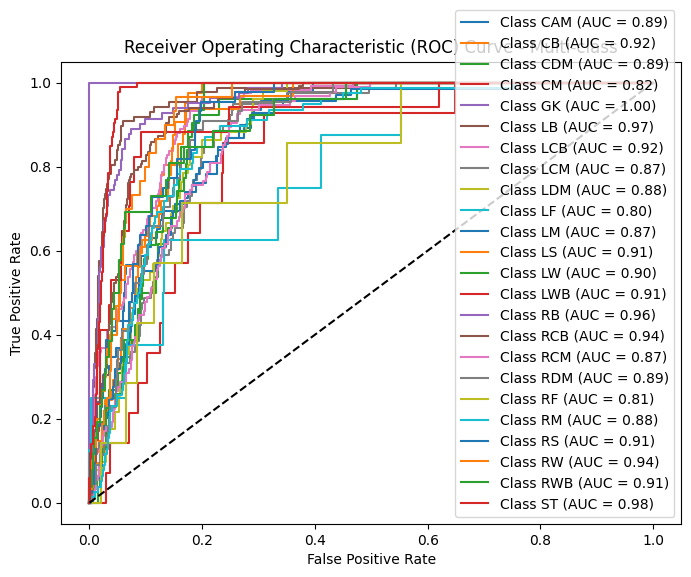

In [528]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Predict probabilities for each class
y_prob = best_rf_classifier.predict_proba(X_test)

# Binarize the labels for each class
y_test_bin = label_binarize(y_test, classes=best_rf_classifier.classes_)

# Calculate ROC AUC for each class
auc_scores = []
for i in range(len(best_rf_classifier.classes_)):
    auc_score = roc_auc_score(y_test_bin[:, i], y_prob[:, i])
    auc_scores.append(auc_score)
    print(f"Class {best_rf_classifier.classes_[i]} - AUC Score: {auc_score:.2f}")

# Micro-average ROC AUC
micro_auc = roc_auc_score(y_test_bin, y_prob, average='micro')
print(f"Micro-average AUC Score: {micro_auc:.2f}")

# Macro-average ROC AUC
macro_auc = roc_auc_score(y_test_bin, y_prob, average='macro')
print(f"Macro-average AUC Score: {macro_auc:.2f}")

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(best_rf_classifier.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {best_rf_classifier.classes_[i]} (AUC = {auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-class')
plt.legend(loc='lower right')
plt.show()

Feature Importances:
attacking_heading_accuracy: 0.02745440502754945
attacking_crossing: 0.026471021870304312
mentality_positioning: 0.02455081550176664
defending_standing_tackle: 0.024461937300647732
defending_sliding_tackle: 0.023158723223119942
defending_marking_awareness: 0.023123148875781024
skill_dribbling: 0.021797405519009636
defending: 0.021416111438957598
mentality_interceptions: 0.020719822564428378
attacking_finishing: 0.02024267851875509
power_stamina: 0.01978457789599762
movement_acceleration: 0.018883493071229898
movement_sprint_speed: 0.01852611681659499
power_strength: 0.01845001061348781
goalkeeping_diving: 0.018391951422685567
goalkeeping_positioning: 0.018342255656721974
mentality_vision: 0.01783639632817224
skill_ball_control: 0.01775132040521731
shooting: 0.01761813660508848
skill_curve: 0.017512246269933154
attacking_volleys: 0.017488075019604882
skill_long_passing: 0.017452320336980305
pace: 0.01729899049638879
skill_fk_accuracy: 0.01728073548296347
power_long_s

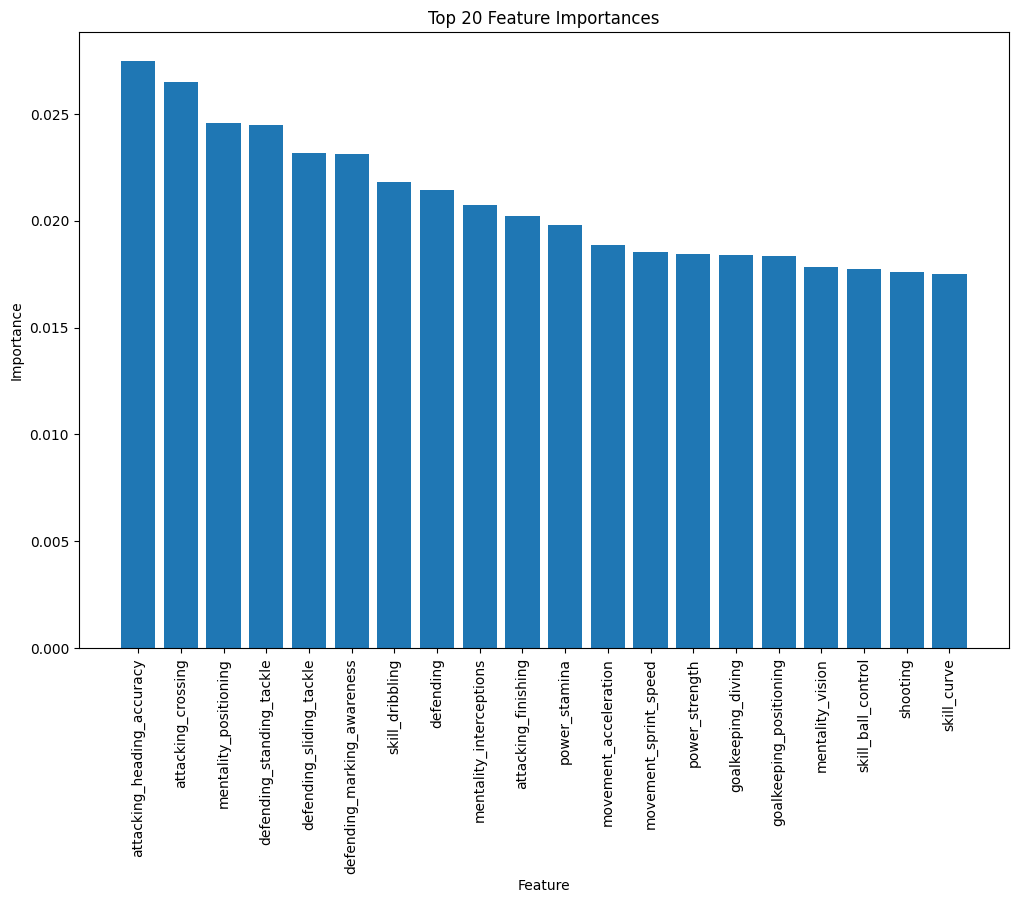

In [529]:
# Print feature importances
print("Feature Importances:")
for f in range(X.shape[1]):
    print(f"{X.columns[indices[f]]}: {feature_importances[indices[f]]}")

# Plot top 20 feature importances
top_n = 20
plt.figure(figsize=(12, 8))
plt.title(f"Top {top_n} Feature Importances")
plt.bar(range(top_n), feature_importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), X.columns[indices[:top_n]], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

In [535]:
# Make predictions on the test set using the best model
test_predictions = best_rf_classifier.predict(df_t) 

# Produce .csv for Kaggle testing
test_predictions_submit = pd.DataFrame({"id": df_t["id"], "position": test_predictions})
test_predictions_submit.to_csv("test_predictions_submit.csv", index=False)


## XGBoost

it gives worse metrics, than Random Forest

In [146]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()
# Fit and transform the 'position' column
df_tr['position_encoded'] = label_encoder.fit_transform(df_tr['position'])

C:\Users\bakwe\AppData\Local\Temp\ipykernel_6904\3135796667.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tr['position_encoded'] = label_encoder.fit_transform(df_tr['position'])


In [147]:
df_tr = df_tr.drop(columns=['position', 'id'])

In [148]:
# Assuming 'target' is your target variable and the rest are features
X_xgb = df_tr.iloc[:, :-1]
y_xgb = df_tr.iloc[:, -1]

# Now perform the train-test split
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=99)

In [149]:

xgb_model = xgb.XGBClassifier()

params = {
    'min_child_weight': [1, 3, 5, 7, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0], 
    'max_depth': [3, 4, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1]
}

random_cv = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=params,
    cv=5,
    n_iter=5,
    scoring='roc_auc',
    n_jobs=1, 
    verbose=0, 
    return_train_score=True,
    random_state=121
)
random_cv.fit(X_train_xgb, y_train_xgb)


c:\Users\bakwe\my_env2\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\bakwe\my_env2\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\bakwe\my_env2\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\bakwe\my_env2\lib\site-packages\sklearn\metrics\_scorer.py", line 367, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
c:\Users\bakwe\my_env2\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=5, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 4, 5, 7, 9],
                                        'min_child_weight': [1, 3, 5, 7, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=121, return_train_score=True,
                   scoring='roc_auc')

In [150]:
random_cv.best_params_

{'subsample': 0.8,
 'min_child_weight': 3,
 'max_depth': 4,
 'learning_rate': 0.01,
 'gamma': 1.5,
 'colsample_bytree': 0.6}

In [151]:
xgb_model = xgb.XGBClassifier(
    colsample_bytree=0.6,
    gamma=1.5,
    max_depth=4,
    min_child_weight=3,
    subsample=0.8,
    learning_rate = 0.01
)

from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train_xgb
)

from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train_xgb = sc.fit_transform(X_train_xgb)
X_test_xgb = sc.transform(X_test_xgb)
xgb_model.fit(X_train_xgb, y_train_xgb.ravel(), sample_weight=classes_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [152]:
xgb_model.score(X_train_xgb, y_train_xgb)

0.5400652646845541

In [153]:
target=xgb_model.predict(X_test_xgb)

In [154]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test_xgb, target)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 36.98%


In [155]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_xgb, target)

In [156]:
cmd_obj=ConfusionMatrixDisplay(cm)

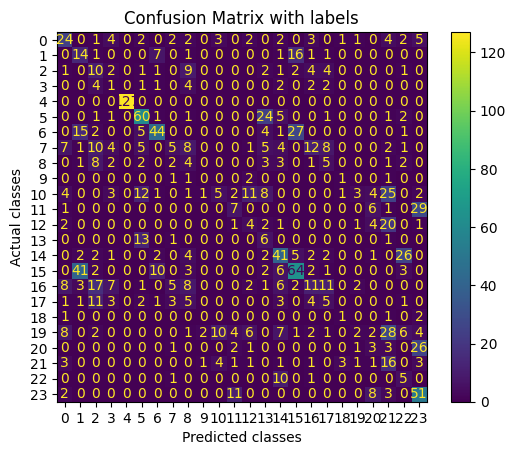

In [157]:
cmd_obj.plot()

cmd_obj.ax_.set(
    title='Confusion Matrix with labels',
    xlabel = 'Predicted classes',
    ylabel = 'Actual classes'
)
plt.show()

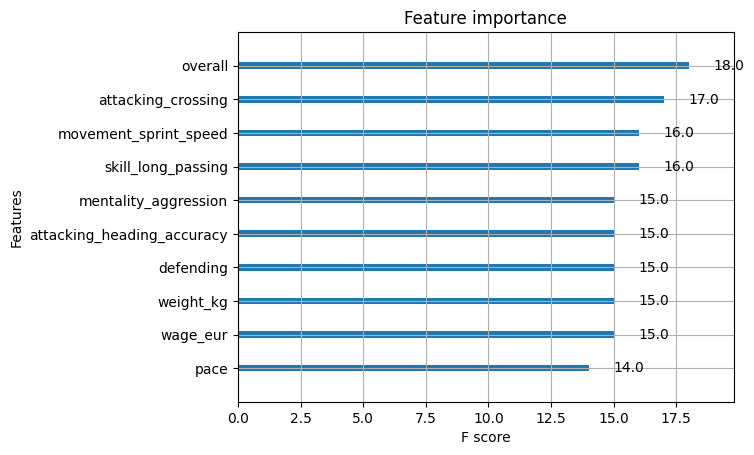

In [158]:
# Convert DataFrame columns to a list for feature_names
feature_names = X_xgb.columns.tolist()

# Create the DMatrix with feature names converted to a list
dtrain = xgb.DMatrix(X_xgb, label=y_xgb, feature_names=feature_names)

# Define your parameters for xgboost
params = {
}

# Train the model
model = xgb.train(params, dtrain, num_boost_round=10)

# Plot feature importance for the top 5 features
ax = xgb.plot_importance(model, max_num_features=10)

# Show the plot
plt.show()